In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Lambda,Conv2D,MaxPooling2D,UpSampling2D,Activation,BatchNormalization,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import seaborn as sns
from time import time
from sklearn import manifold, datasets
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding as sp
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import ndimage
from sklearn import manifold, datasets

from matplotlib import pyplot as plt


Using TensorFlow backend.
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasan/anaconda3/e

In [2]:

import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

nmi = normalized_mutual_info_score
ami = adjusted_mutual_info_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(- w)
    acc= sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    
    print('\n')
    print("Accuracy using linear assignment : ",acc)
    print('\n')
    print("Normalized Mutual Info Score : ",nmi(y_true,y_pred))
    print('\n')
    print("Adjusted Mutual Info Score : ",ami(y_true,y_pred))

In [3]:
import matplotlib.pyplot as plt

def graph_plot_loss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [5]:
#Loading the fashion MNIST dataset

cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
#preprocess the data
max_value = float(X_train.max())
x_train = X_train.astype('float32') / max_value
x_test = X_test.astype('float32') / max_value

In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
img_shape = (32, 32, 3)    # for MNIST
batch_size = 500
latent_dim = 2  # Number of latent dimension parameters
from keras import backend as K
import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K  

In [9]:
# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [10]:

# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(3, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

# Custom Loss

In [11]:

# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [12]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [13]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=7,
        batch_size=batch_size,
        validation_data=(x_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/7
50000/50000 [==============================] - 11s 227us/step - loss: 0.6831 - val_loss: 0.6752
Epoch 2/7
50000/50000 [==============================] - 9s 186us/step - loss: 0.6647 - val_loss: 0.6568
Epoch 3/7
50000/50000 [==============================] - 9s 186us/step - loss: 0.6478 - val_loss: 0.6404
Epoch 4/7
50000/50000 [==============================] - 9s 189us/step - loss: 0.6383 - val_loss: 0.6382
Epoch 5/7
50000/50000 [==============================] - 9s 187us/step - loss: 0.6372 - val_loss: 0.6383
Epoch 6/7
50000/50000 [==============================] - 9s 188us/step - loss: 0.6368 - val_loss: 0.6375
Epoch 7/7
50000/50000 [==============================] - 9s 188us/step - loss: 0.6366 - val_loss: 0.6373


In [14]:
y_test=y_test.reshape(y_test.shape[0])

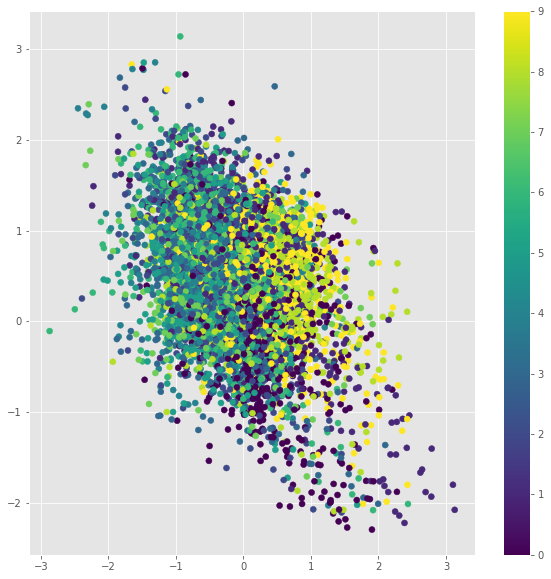

In [15]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [25]:
#Kmeans with Convolution Autoencoder

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(x_valid_noTest_encoded)

predicted_labels=model.predict(x_valid_noTest_encoded)




In [26]:

from sklearn.metrics import confusion_matrix

print ('Results of Kmeans with Convolution Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))


Results of Kmeans with Convolution Autoencoder


Confusion Matrix: 

[[231  16 109  17  88 118  55 245  58  63]
 [ 27  76 174  65  80 190  43 120 181  44]
 [108  77  53  63  20 275  77 176 142   9]
 [ 76 148  68  68  13 216 145 123 129  14]
 [ 34 164  59  55  10 274 124 123 156   1]
 [ 58 139  49  36   6 235 202 160 111   4]
 [ 57 133  36 119   6 266  64 111 198  10]
 [ 44  90 154  31  50 205 151 190  81   4]
 [ 38  41 255  13 207 120  71 187  50  18]
 [ 44  30 332   9 147 140  25 143 100  30]]


In [27]:

import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

nmi = normalized_mutual_info_score
ami = adjusted_mutual_info_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(- w)
    acc= sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    
    print('\n')
    print("Accuracy using linear assignment : ",acc)
    print('\n')
    print("Normalized Mutual Info Score : ",nmi(y_true,y_pred))
    print('\n')
    print("Adjusted Mutual Info Score : ",ami(y_true,y_pred))

In [28]:
acc(y_test,predicted_labels)



Accuracy using linear assignment :  0.1915


Normalized Mutual Info Score :  0.06908317015403745


Adjusted Mutual Info Score :  0.0653058863874226


/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in versio

In [16]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                524320    
__________

In [22]:
from scipy.stats import norm
# Display a 2D manifold of the digits
n = 10  # figure with 20x20 digits
digit_size = 32
nb_color = 3
figure = np.zeros((digit_size * n, digit_size * n))
# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


In [23]:
im_shape = x_train[0].shape

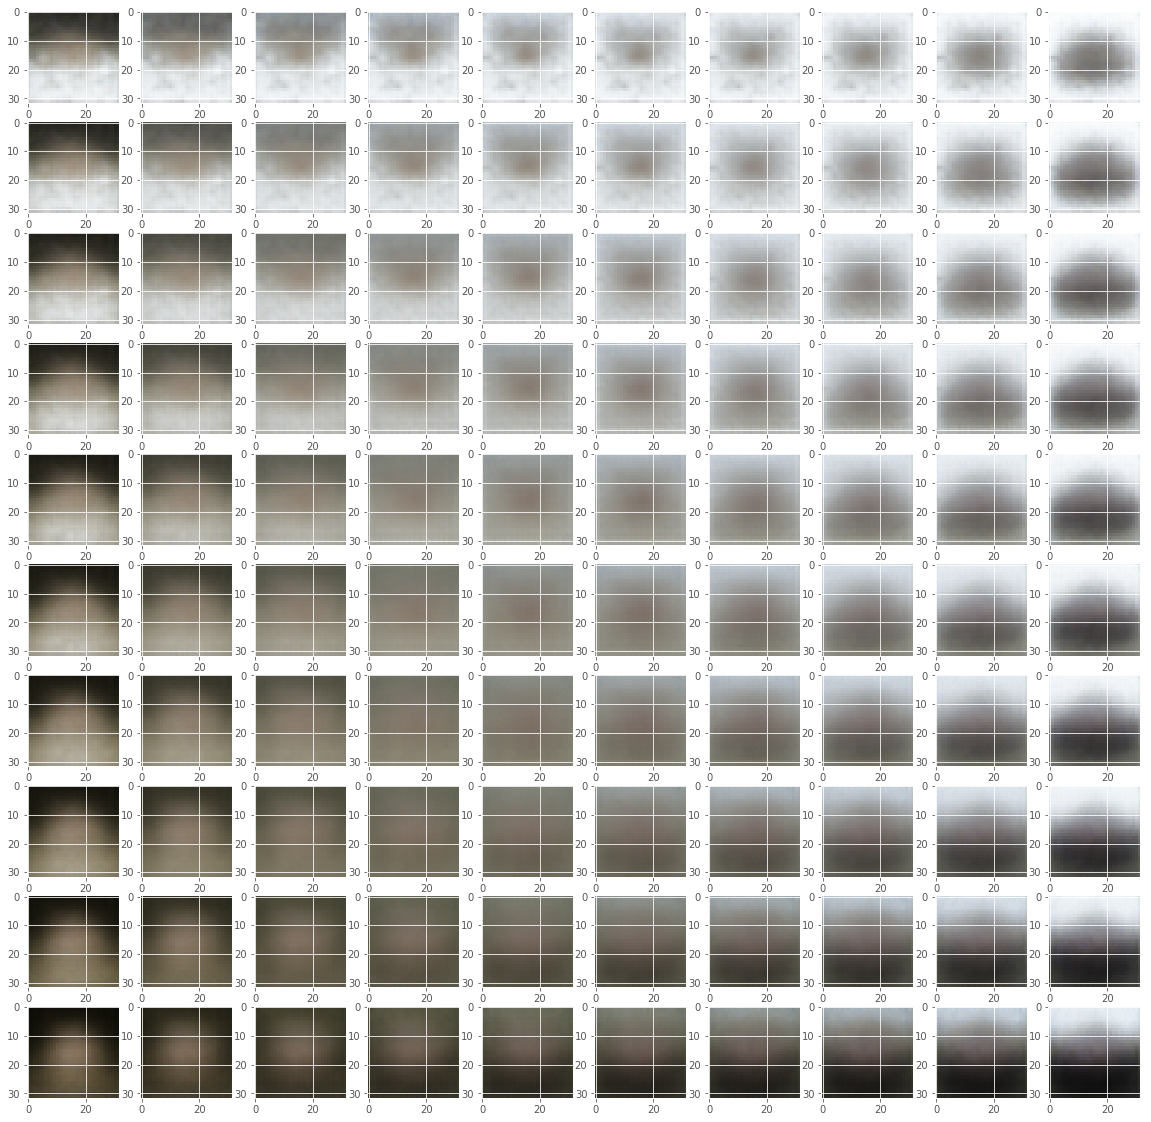

In [24]:
plt.figure(figsize=(20,20))
total =1
# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(im_shape)
        #print(digit.shape)
        plt.subplot(n, n, total)
        plt.imshow(digit.transpose(0,1,2))
        total += 1
plt.savefig('cifar_vae_dist.pdf')
plt.show()

In [20]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

ValueError: Error when checking input: expected input_2 to have 2 dimensions, but got array with shape (10000, 32, 32, 3)

In [15]:
#Now perform dimension reduction

X_train_dr=encoder.predict(x_train)
X_test_dr=encoder.predict(x_test)

print(X_train_dr.shape,X_test_dr.shape)

(50000, 128) (10000, 128)


In [19]:
X1 = X_train_dr[:5000,:]
Y= y_train[:5000]
X1.shape

(5000, 128)

In [20]:
np.random.seed(0)

def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((16, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X1, Y)

In [21]:
y.shape

(10000, 1)

In [22]:
# Visualize the clustering
def plot_clustering(X_red,X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(8, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

In [23]:
# 2D embedding of the dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X1)
print("Done.")

Computing embedding
Done.


In [24]:
X_red.shape

(5000, 2)

ward : 0.52s
average : 0.51s
complete : 0.46s


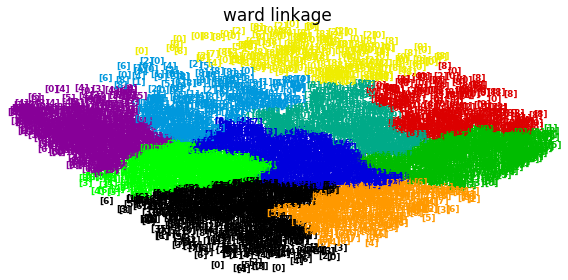

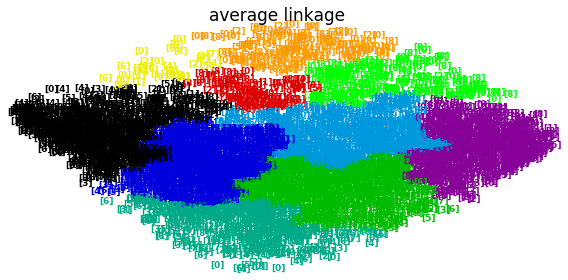

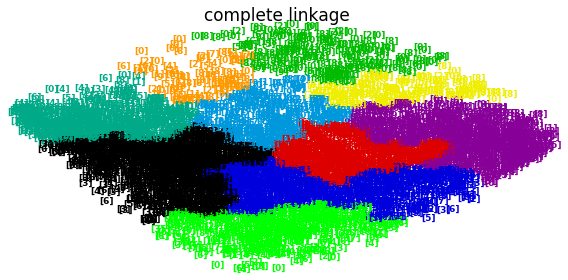

In [25]:
from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))

    plot_clustering(X_red,X, clustering.labels_, "%s linkage" % linkage)
plt.show()

In [26]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

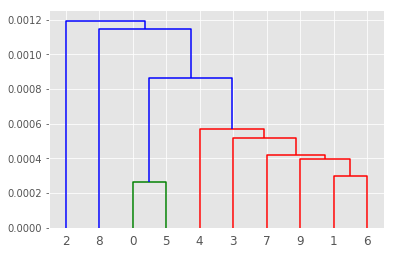

In [27]:

Z = hierarchy.linkage(X_red[:10,:], 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)